In [51]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import cv2
import os

import torch
from torch import nn
from torch.nn import functional as F
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
from torch.utils import data as data_utils
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms, datasets, models
from torch import topk

In [52]:
def get_feature_maps(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def construct_cam(CAMs, width, height, orig_image, class_idx, all_classes, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
        cv2.imwrite("CAM_visualizations_outputs/lion_heat_map.jpg", heatmap)
        result = heatmap * 0.35 + orig_image * 0.6
        # put class label text on the result
        cv2.putText(result, all_classes[class_idx[i]], (20, 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        print(result.shape)
        cv2.imshow("cam_vis",result/255.)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imwrite(f"{save_name}.jpg", result)
        plt.imshow(result/255.)

In [53]:
def synset_classes(file_name):
    imagenet_classes = []
    with open(file_name, 'r') as f:
        lines = f.readlines()
        labels = [line.split('\n') for line in lines]
        for label_list in labels:
            current_class = [name.split(',') for name in label_list][0][0][10:]
            imagenet_classes.append(current_class)
    return imagenet_classes

# Imagenet classes
imagenet_classes = synset_classes('synset_mapping.txt')

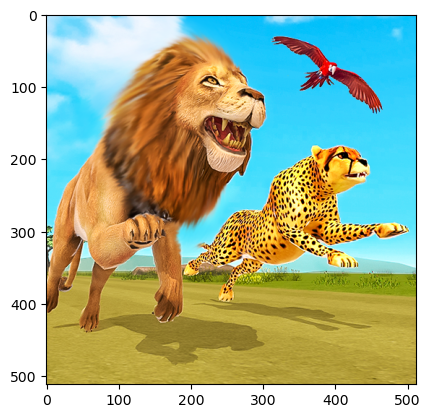

In [54]:
# read and visualize the image
img = cv2.imread('test_images/lion_tiger_bird.png')
img_copy = img.copy()
img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
h, w , n_channels = img.shape

plt.imshow(img)

C:\Users\jairam\AppData\Local\Temp\ipykernel_9184\3974952849.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


(512, 512, 3)


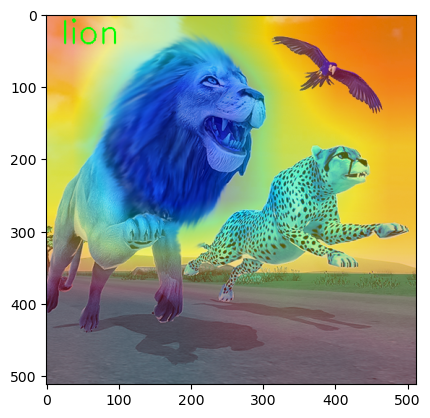

In [55]:
# load the model
model = models.resnet18(pretrained=True).eval()
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('layer4').register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

input_size = 224
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(input_size),
    # transforms.RandomSizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transformed_img = trans(img)
# add batch dimensiond
# print(transformed_img.shape)   #torch.Size([3, 224, 224])
transformed_img = transformed_img.unsqueeze(0)   #to make it a batch of just single image   torch.Size([1, 3, 224, 224])
outputs = model(transformed_img)    #torch.Size([1, 1000])

probs = F.softmax(outputs).data.squeeze()
#get top k class indices based on softmax probs
predicted_class_idx = topk(probs, 1)[1].int()
# predicted_class_idx = torch.Tensor([291]).int()
# print(topk(probs, 100))

CAMs = get_feature_maps(features_blobs[0], weight_softmax, class_idx)
construct_cam(CAMs, w, h, img_copy, class_idx, all_classes, 'CAM_visualizations_outputs/lion_CAM')